In [1]:
import os
files = os.listdir('../../pythia/results/bias-evals/')

In [2]:
import json
def read_file(f):
    with open('../../pythia/results/bias-evals/' + f, 'r') as f:
        return json.load(f)

In [3]:
def parse_json(f):
    data = read_file(f)
    # get all values where key contains 'english' in a new dict 
    english = {k: v for k, v in data['results'].items() if 'english' in k}
    # get only the pct_stereotype key from the new dict
    english = {k: v['pct_stereotype'] for k, v in english.items()}
    return english

In [4]:
parse_json(r'pythia-1.3b-deduped-step69000_eval_results_01-22-2023-09-20-33.json')

{'crows_pairs_english_gender': 0.61875,
 'crows_pairs_english': 0.6118067978533095}

In [5]:
pythia_files = []
intervened_files = []
for f in files:
  if f.startswith('pythia'):
    pythia_files.append(f)
  else:
    intervened_files.append(f)

In [6]:
pythia_res = {}
intervened_res = {}

In [7]:
sizes_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    sizes_pythia.append(split_name[1])
sizes_pythia = list(set(sizes_pythia))

steps_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    steps_pythia.append(int(split_name[3].split('_')[0][4:]))
steps_pythia = list(set(steps_pythia))

sizes_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    sizes_intervened.append(split_name[1])
sizes_intervened = list(set(sizes_intervened))

steps_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    steps_intervened.append(int(split_name[3].split('_')[0][4:]))
steps_intervened = list(set(steps_intervened))

In [8]:
task_names = ['crows_pairs_english_gender']

In [9]:
for sizes in sizes_pythia:
    for steps in steps_pythia:
        for f in pythia_files:
            if sizes in f and str(steps) in f:
                pythia_res[(sizes, steps)] = parse_json(f)

In [10]:
for sizes in sizes_intervened:
    for steps in steps_intervened:
        for f in intervened_files:
            if sizes in f and str(steps) in f:
                intervened_res[(sizes, steps)] = parse_json(f)

In [11]:
intervened_res[('1.3b', 69000)]

{'crows_pairs_english_physical_appearance': 0.5972222222222222,
 'crows_pairs_english_socioeconomic': 0.5421052631578948,
 'crows_pairs_english': 0.56768038163387,
 'crows_pairs_english_sexual_orientation': 0.7634408602150538,
 'crows_pairs_english_nationality': 0.5185185185185185,
 'crows_pairs_english_religion': 0.7477477477477478,
 'crows_pairs_english_gender': 0.5625,
 'crows_pairs_english_disability': 0.6307692307692307,
 'crows_pairs_english_age': 0.5714285714285714,
 'crows_pairs_english_autre': 0.6363636363636364,
 'crows_pairs_english_race_color': 0.5118110236220472}

In [12]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(pythia_dict, intervened_dict, task_name, model_size):
    ls_pythia = []
    ls_intervened = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # plot intervened
    for key in intervened_dict:
        if key[0] == model_size:
            ls_intervened.append((key[1], intervened_dict[key][task_name]))
    # Sort by step
    ls_intervened = sorted(ls_intervened, key=lambda x: x[0])
    # plot
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label='Pythia')
    plt.plot([x[0] for x in ls_intervened], [x[1] for x in ls_intervened], label='Intervened')
    plt.xlabel('Steps')
    plt.ylabel('Pct stereotype')
    plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    plt.legend()
    plt.show()

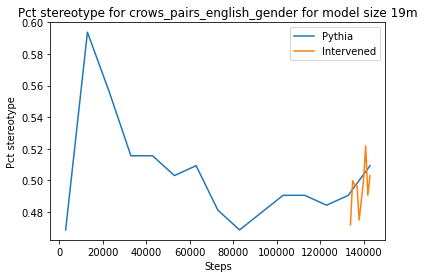

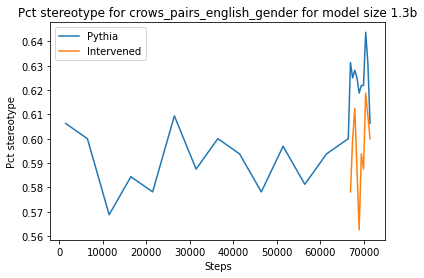

In [13]:
# Make all plots
for task in task_names:
    for size in sizes_pythia:
        plot_results(pythia_res, intervened_res, task, size)